# Week 03

Content:

1. SVD 
2. TF-IDF
3. argmax
4. monotone function
5. Latent Semantic Analysis

## 1. SVD

Recall from the lectures, that we can decompose any matrix using an SVD: 
$$\textbf{A} = \textbf{U} \, \Sigma \, \textbf{V}^T$$


### Question
Our goal here is to calculate the SVD of $\textbf{A}^{-1}$

1. Show that $\textbf{U}^{-1} = \textbf{U}^T$
2. Does the same hold for $\textbf V$?
3. What is the inverse matrix of $\Sigma$ provided that the diagonal entries $\sigma_i$ are not zero and $\Sigma$ is a square matrix?
4. Combine the results to derive the SVD of $\textbf{A}^{-1}$

## 2.  TFIDF

Let $X$ be tf-idf matrix.

1. Check that the the result in $(i,j)$ of $X^T X$ is equal to the dot-product of document $d_i \cdot d_j$
2. Check that $X^T X$ is symmetric

## 3. argmax
let $f(x1, x2) = x_1x_2 - x_1^2 - 2x_2^2$ for $x_i \in [-5, 5]$
1. plot the function to verify visually, that there is a maximum
2. what is $\text{argmax}_{x_1,x_2}f(x_1, x_2)$ \
   **see below: Maximum at (0,0) with value f(0,0) = 0**
3. in general, what is the value of $g(\text{argmax}_x g(x))$ for a real-valued $g$? \
   **Wenn $g()$ das $x$ übergeben wird, was die Funktion maximiert, dann ist $g()$ maximal. $g(\text{argmax}_x g(x)) = \text{max}_x g()$**
   

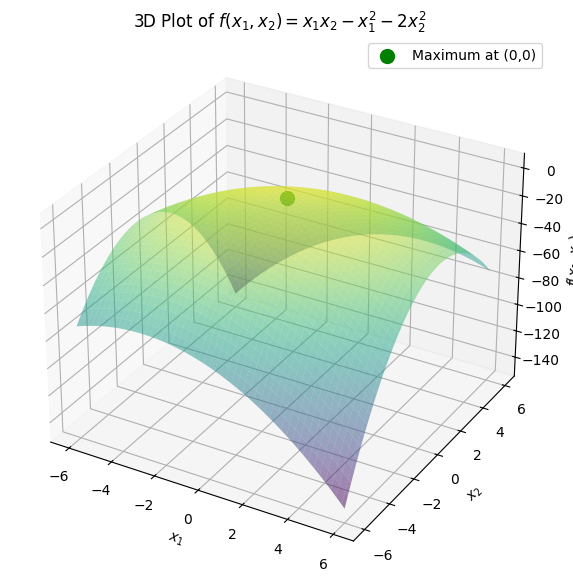

2. argmax: f(0,0) = 0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Achsen und Grid definieren
x1 = np.linspace(-6, 6, 100)
x2 = np.linspace(-6, 6, 100)
X1, X2 = np.meshgrid(x1, x2)

# Funktion definieren
def f(x1, x2):
    return x1 * x2 - x1**2 - 2 * x2**2
Z = f(X1, X2)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, f(0, 0), color='green', s=100, label="Maximum at (0,0)")
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.5)

# Labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1, x_2)$')
ax.set_title('3D Plot of $f(x_1, x_2) = x_1x_2 - x_1^2 - 2x_2^2$')
ax.legend()

plt.show()

print(f"2. argmax: f(0,0) = {f(0,0)}")

## 4. Monotone function
1. let m be a monotone increasing function, i.e. $m(x) \le m(y)$ for all $x \le y$ and $f$ be an arbitrary function. Is it true that $\text{argmax}_x f(x) = \text{argmax}_x m(f(x))$? \
   **Ja ist es. Da $m()$ monoton steigend ist, wird das Maximum von $f()$ auch das Maximum von $m(f())$ sein.**
2. explain, how you can use the result from 4. to derive the formula in the lecture, i.e. $$c_{\text{NB}} = \arg\max_{c \in C} \left( \log \mathbb{P}[c] + \sum_{w_i \in V} \log \mathbb{P}[w_i|c] \right)$$

## 5. TF-IDF and Latent Semantic Analysis

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from collections import Counter
import matplotlib.pyplot as plt

Importing the data:

In [4]:
data_folder = Path("WikiQACorpus/WikiQACorpus/")

train = pd.read_csv(data_folder/"WikiQA-train.txt", header=None, sep = r'\t', engine='python')

column_names = ["q", "a", "is_answer"]
train.columns = column_names

train.sort_values("q", inplace=True)
train

,q,a,is_answer
987,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"Currently , Nevada is the only state to allow brothel prostitution , the terms of which are stipulated in the Nevada Revised Statutes .",0
991,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"Street prostitution , `` pandering , '' and living off of the proceeds of a prostitute remain illegal under Nevada law , as elsewhere in the country .",0
984,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"The regulation of prostitution in the United States is not among the enumerated powers of the federal government ; Under the Tenth Amendment to the United States Constitution , it is therefore exclusively the domain of the states to permit , prohibit , or otherwise regulate commercial sex , except insofar as Congress may regulate it as part of interstate commerce with laws like the Mann Act .",0
990,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"The other counties theoretically allow brothel prostitution , but some of these counties currently have no active brothels .",0
989,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"All forms of prostitution are illegal in Clark County ( which contains the Las Vegas–Paradise metropolitan area ) , Washoe County ( which contains Reno ) , Carson City , Douglas County , and Lincoln County .",0
...,...,...,...
7295,who wrote white christmas,"According to the Guinness Book of World Records , the version sung by Bing Crosby is the best-selling single of all time , with estimated sales in excess of 50 million copies worldwide .",0
7296,who wrote white christmas,Accounts vary as to when and where Berlin wrote the song .,0
7297,who wrote white christmas,"One story is that he wrote it in 1940 , in warm La Quinta , California , while staying at the La Quinta Hotel , a frequent Hollywood retreat also favored by writer-producer Frank Capra , although the Arizona Biltmore also claims the song was written there .",0
7298,who wrote white christmas,"He often stayed up all night writing — he told his secretary , `` Grab your pen and take down this song .",0


Add a counter within each group of questions (group size):

In [5]:
train['q_count'] = train.groupby('q')['q'].transform('count')
train.query('q_count > 1')

,q,a,is_answer,q_count
987,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"Currently , Nevada is the only state to allow brothel prostitution , the terms of which are stipulated in the Nevada Revised Statutes .",0,9
991,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"Street prostitution , `` pandering , '' and living off of the proceeds of a prostitute remain illegal under Nevada law , as elsewhere in the country .",0,9
984,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"The regulation of prostitution in the United States is not among the enumerated powers of the federal government ; Under the Tenth Amendment to the United States Constitution , it is therefore exclusively the domain of the states to permit , prohibit , or otherwise regulate commercial sex , except insofar as Congress may regulate it as part of interstate commerce with laws like the Mann Act .",0,9
990,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"The other counties theoretically allow brothel prostitution , but some of these counties currently have no active brothels .",0,9
989,HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840 'S,"All forms of prostitution are illegal in Clark County ( which contains the Las Vegas–Paradise metropolitan area ) , Washoe County ( which contains Reno ) , Carson City , Douglas County , and Lincoln County .",0,9
...,...,...,...,...
7295,who wrote white christmas,"According to the Guinness Book of World Records , the version sung by Bing Crosby is the best-selling single of all time , with estimated sales in excess of 50 million copies worldwide .",0,7
7296,who wrote white christmas,Accounts vary as to when and where Berlin wrote the song .,0,7
7297,who wrote white christmas,"One story is that he wrote it in 1940 , in warm La Quinta , California , while staying at the La Quinta Hotel , a frequent Hollywood retreat also favored by writer-producer Frank Capra , although the Arizona Biltmore also claims the song was written there .",0,7
7298,who wrote white christmas,"He often stayed up all night writing — he told his secretary , `` Grab your pen and take down this song .",0,7


Exclude:
 - Questions with too less answers (less than *min_q*)
 - Questions that have no true answer

In [6]:
def filter_data(df, min_q = 5):
    df['q_count'] = df.groupby('q')['q'].transform('count')
    df['has_correct_answer'] = df.groupby('q')['is_answer'].transform('max')
    return df.query("q_count >= @min_q").query("has_correct_answer == 1")

print(f"before: {train.shape}")
train = filter_data(train)
print(f"after: {train.shape}")

before: (20360, 4)
after: (8108, 5)


In [26]:
train.describe()

,is_answer,q_count,has_correct_answer
count,8108.000000,8108.000000,8108.0
mean,0.101505,14.704243,1.0
std,0.302014,6.458040,0.0
min,0.000000,5.000000,1.0
25%,0.000000,10.000000,1.0
50%,0.000000,14.000000,1.0
75%,0.000000,19.000000,1.0
max,1.000000,30.000000,1.0


Looks okay.

Remark: this data might be subotpimal for LSA, since the answers are very short and the questions are very similar.

Data preprocessing:
 - your choice. Candidate operations include stopword removal, lowercasing, remove answers than have only one or two words after stopword removal, etc.

In [12]:
_ = nltk.download('stopwords')
_ = nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()

    tokens = word_tokenize(text)
    
    # Removing punctuation
    tokens = [word for word in tokens if word.isalnum()]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)

train['q_clean'] = train['q'].apply(preprocess_text)
train['a_clean'] = train['a'].apply(preprocess_text)

# Remove questions with less than 2 words
train = train[train['a_clean'].str.split().str.len() > 1]

train

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Seya.Schmassmann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Seya.Schmassmann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,q,a,is_answer,q_count,has_correct_answer,q_clean,a_clean
6804,How Do You Get Hepatitis C,"In some cases , those with cirrhosis will go on to develop liver failure , liver cancer or life-threatening esophageal and gastric varices .",0,13,1,get hepat c,case cirrhosi go develop liver failur liver cancer esophag gastric varic
6802,How Do You Get Hepatitis C,"Hepatitis C is an infectious disease affecting primarily the liver , caused by the hepatitis C virus ( HCV ) .",0,13,1,get hepat c,hepat c infecti diseas affect primarili liver caus hepat c viru hcv
6803,How Do You Get Hepatitis C,"The infection is often asymptomatic , but chronic infection can lead to scarring of the liver and ultimately to cirrhosis , which is generally apparent after many years .",0,13,1,get hepat c,infect often asymptomat chronic infect lead scar liver ultim cirrhosi gener appar mani year
6805,How Do You Get Hepatitis C,"HCV is spread primarily by blood-to-blood contact associated with intravenous drug use , poorly sterilized medical equipment and transfusions .",1,13,1,get hepat c,hcv spread primarili contact associ intraven drug use poorli steril medic equip transfus
6808,How Do You Get Hepatitis C,only infects humans and chimpanzees .,0,13,1,get hepat c,infect human chimpanze
...,...,...,...,...,...,...,...
7295,who wrote white christmas,"According to the Guinness Book of World Records , the version sung by Bing Crosby is the best-selling single of all time , with estimated sales in excess of 50 million copies worldwide .",0,7,1,wrote white christma,accord guin book world record version sung bing crosbi singl time estim sale excess 50 million copi worldwid
7296,who wrote white christmas,Accounts vary as to when and where Berlin wrote the song .,0,7,1,wrote white christma,account vari berlin wrote song
7297,who wrote white christmas,"One story is that he wrote it in 1940 , in warm La Quinta , California , while staying at the La Quinta Hotel , a frequent Hollywood retreat also favored by writer-producer Frank Capra , although the Arizona Biltmore also claims the song was written there .",0,7,1,wrote white christma,one stori wrote 1940 warm la quinta california stay la quinta hotel frequent hollywood retreat also favor frank capra although arizona biltmor also claim song written
7298,who wrote white christmas,"He often stayed up all night writing — he told his secretary , `` Grab your pen and take down this song .",0,7,1,wrote white christma,often stay night write told secretari grab pen take song


Check out [gensim](https://radimrehurek.com/gensim/models/lsimodel.html) for doing LSA and full tf-idf:
 - do a full tf-idf and compare with LSA using different values for the low-rank approximation (*num_topics* in *LsiModel*)
 - as a measure of success: when retrieving the top-k best matching documents for a question, check if you get the correct answer within your top-k return (see function below)

In [18]:
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import LsiModel, TfidfModel

#TF-IDF
dictionary = corpora.Dictionary(train['a_clean'].str.split())
corpus = [dictionary.doc2bow(text.split()) for text in train['a_clean']]

tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

# LSA
num_topics_list = [10, 50, 100]
lsa_models = {num: LsiModel(tfidf_corpus, id2word=dictionary, num_topics=num) for num in num_topics_list}

# Function to retrieve top-k matches
def get_top_k_matches(question, k=5, num_topics=50):
    question_bow = dictionary.doc2bow(preprocess_text(question).split())
    question_lsa = lsa_models[num_topics][question_bow]
    
    similarities = []
    for i, doc in enumerate(tfidf_corpus):
        doc_lsa = lsa_models[num_topics][doc]
        similarity = cosine_similarity([np.array(list(dict(question_lsa).values()))], 
                               [np.array(list(dict(doc_lsa).values()))])[0][0]

        similarities.append((i, similarity))
    
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    return [train.iloc[i]['a'] for i, _ in top_k]

# Evaluate performance
def evaluate_model(k=5, num_topics=50):
    correct = 0
    total = 0
    for _, row in train.iterrows():
        question = row['q']
        correct_answer = row['a']
        top_answers = get_top_k_matches(question, k, num_topics)
        if correct_answer in top_answers:
            correct += 1
        total += 1
    accuracy = correct / total
    print(f"Top-{k} Accuracy with {num_topics} topics: {accuracy:.2%}")

# Run evaluation
evaluate_model()

KeyboardInterrupt: 